In [1]:
pwd

'/Users/ngvngoc/Documents/Projects/medical_visit'

In [2]:
import pandas as pd
from statsforecast import StatsForecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, r2_score

/Users/ngvngoc/Documents/Projects/medical_visit/venv/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
Y_df = pd.read_csv('datasets/combined.csv')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.fillna(0, inplace=True)
Y_df.head()

,y,ds,unique_id
0,17.0,2020-01-02,H99
1,8.0,2020-01-03,H99
2,11.0,2020-01-06,H99
3,14.0,2020-01-07,H99
4,11.0,2020-01-08,H99


In [4]:
Y_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   y          1530 non-null   float64       
 1   ds         1530 non-null   datetime64[ns]
 2   unique_id  1530 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 36.0+ KB


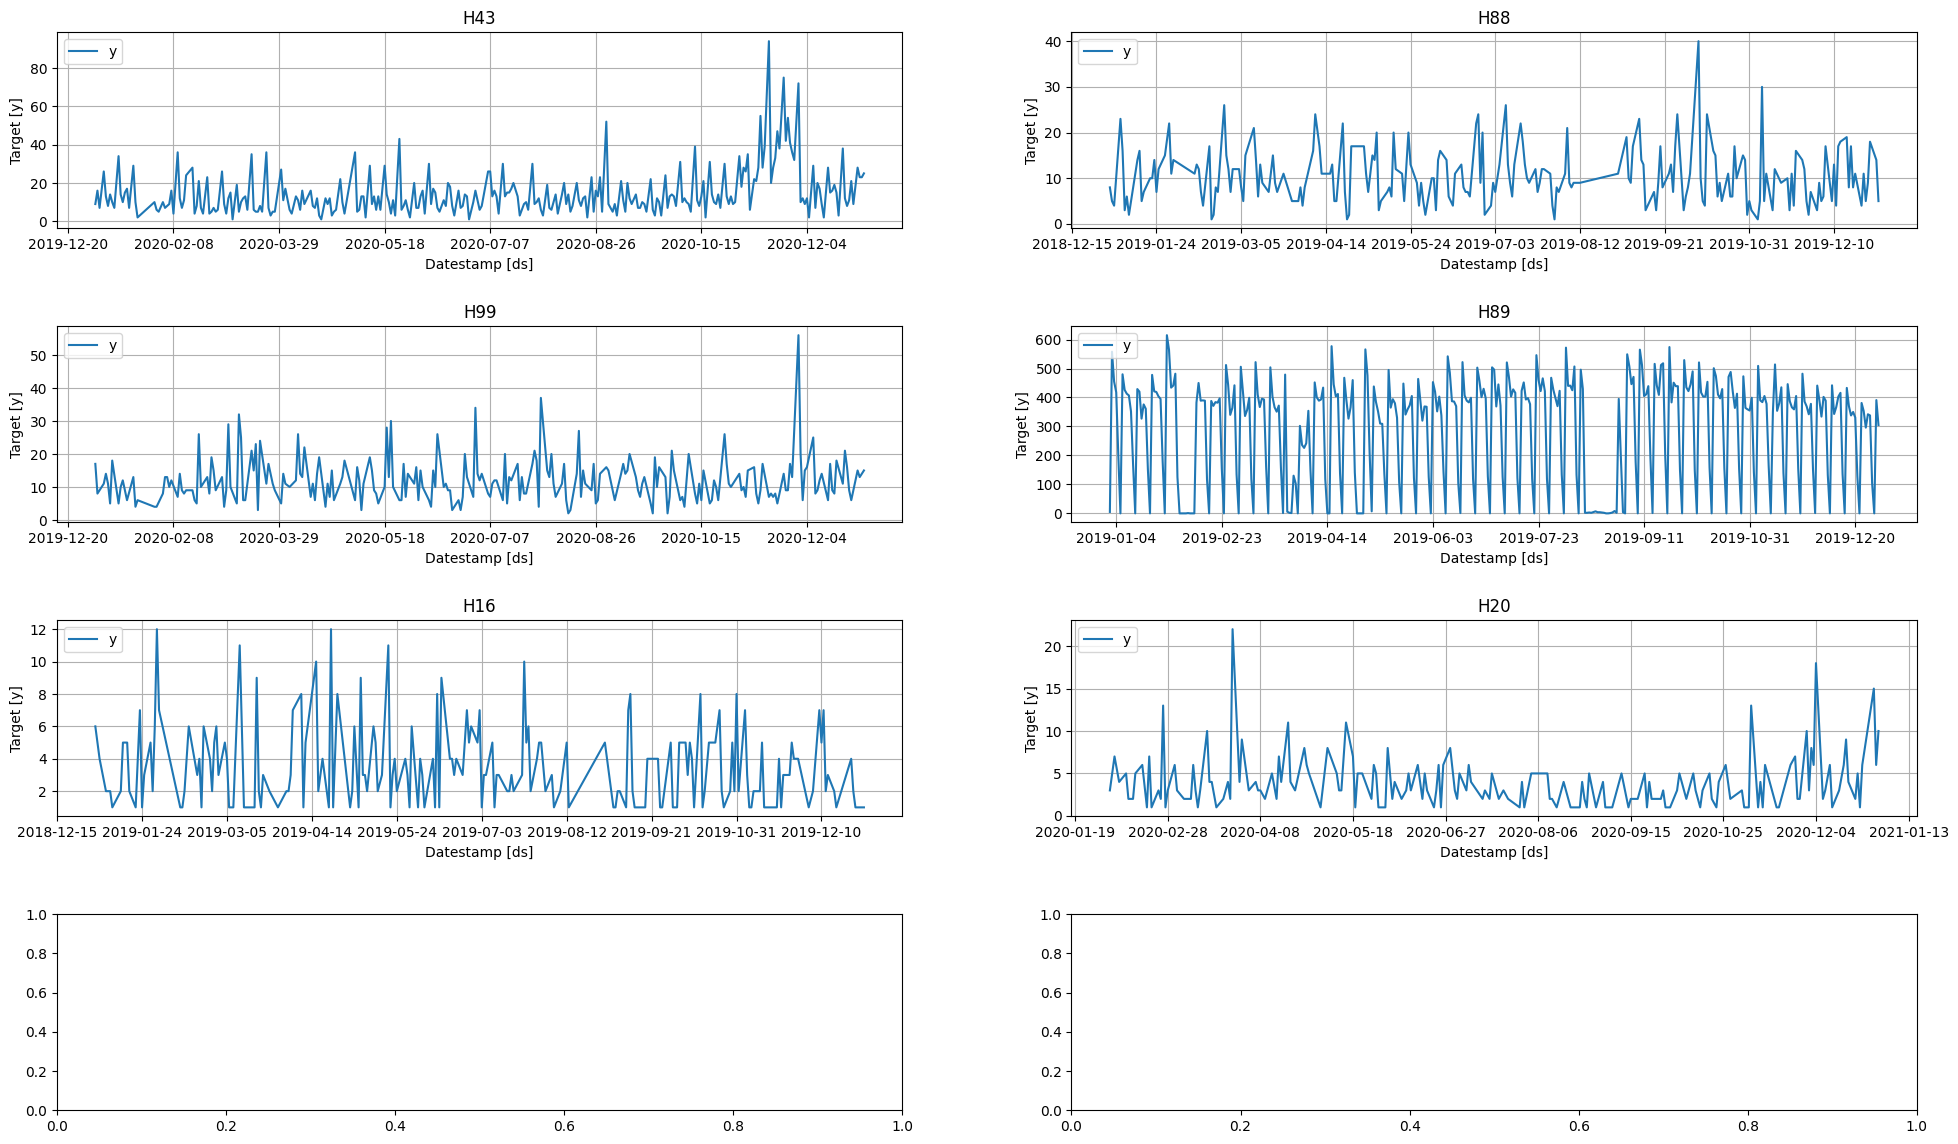

In [5]:
StatsForecast.plot(Y_df)

In [14]:
df_43 = Y_df.loc[Y_df['unique_id'] == 'H99', :]
df_43.head()
StatsForecast.plot(df_43)
df_43.y.max()

/Users/ngvngoc/Documents/Projects/medical_visit/venv/lib/python3.10/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


56.0

/Users/ngvngoc/Documents/Projects/medical_visit/venv/lib/python3.10/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


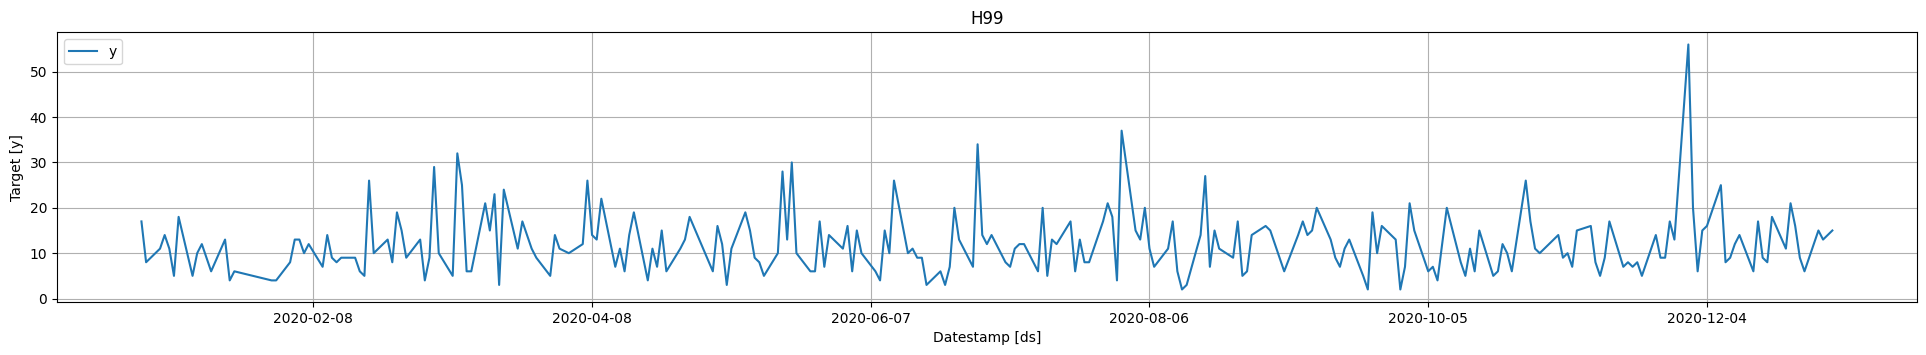

In [15]:
# def replace_outlier(x, upper_limit, lower_limit, mx, mn):
#     if x > upper_limit:
#         return x - (mx - upper_limit)
#     elif x < lower_limit:
#         return x + (lower_limit - mn)
#     else:
#         return x

# upper_limit = df_43['y'].quantile(0.5)  # Use the 80th percentile for upper limit
# lower_limit = df_43['y'].quantile(0.1)  # Use the 20th percentile for lower limit
# mx = df_43['y'].max()  # Maximum value in the 'y' column
# mn = df_43['y'].min()  # Minimum value in the 'y' column

# print(upper_limit, lower_limit, mx, mn)

# # Apply the replace_outlier function to the 'y' column
# df_43.loc[:, 'y'] = df_43['y'].apply(lambda x: replace_outlier(x, upper_limit, lower_limit, mx, mn))

StatsForecast.plot(df_43)
# # df_43

/Users/ngvngoc/Documents/Projects/medical_visit/venv/lib/python3.10/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


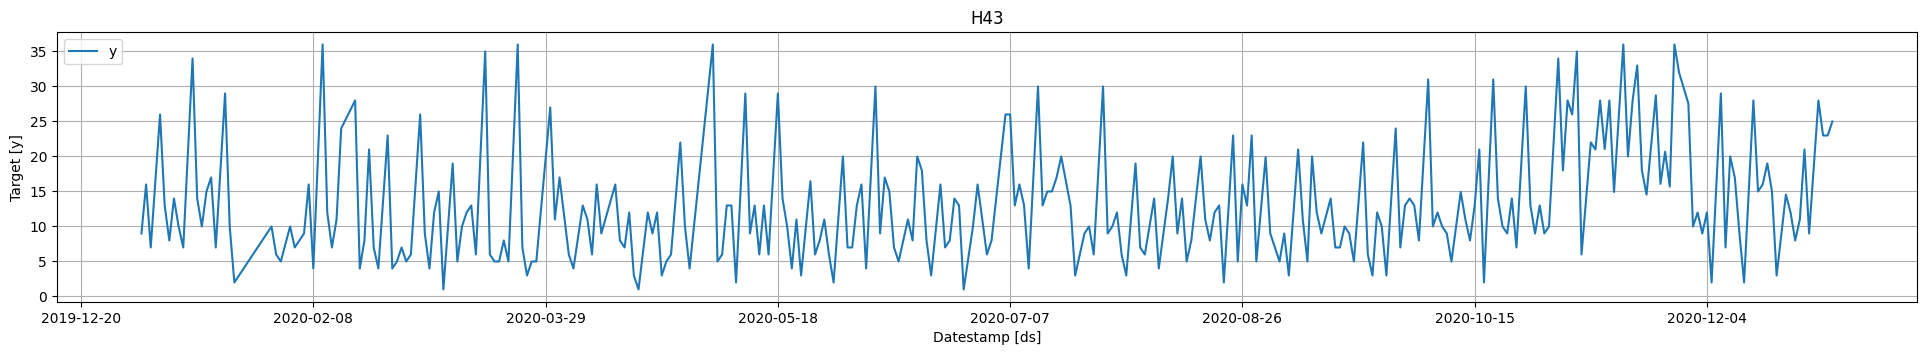

In [16]:
def replace_outlier(x, upper, mx):
    if x > upper:
        return x * upper/mx
    else:
        return x

new_df = Y_df.loc[Y_df['unique_id'] == 'H43', :]

new_df.loc[:, 'y'] = new_df['y'].apply(lambda x: replace_outlier(x, upper=new_df.y.quantile(0.95), mx=new_df.y.max()))

StatsForecast.plot(new_df)
# new_df.y.max()

In [18]:
es_df = new_df[['y', 'ds']]
es_df.columns = ['volume', 'date']

es_df['date'] = pd.to_datetime(es_df['date'])
es_df = es_df[['date', 'volume']].set_index('date')
es_df = es_df.asfreq('D')
es_df.fillna(0, inplace=True)
es_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-01-02 to 2020-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_56021/2925001463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_df['date'] = pd.to_datetime(es_df['date'])


In [19]:
predict_step = 14
y_train, y_test = es_df.iloc[:-predict_step, 0], es_df.iloc[-predict_step:, 0]

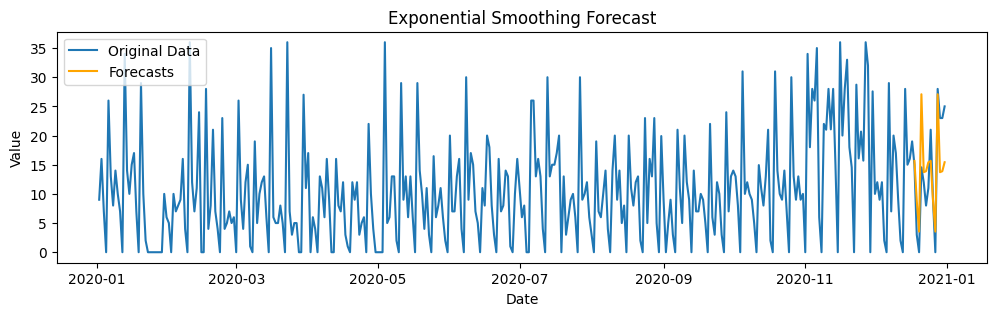

In [20]:
# Fit the exponential smoothing model on the training data
es_model = ExponentialSmoothing(y_train, trend=None, seasonal='additive', seasonal_periods=7)
result = es_model.fit()

# Get the forecasts for the test set
y_pred = result.forecast(steps=len(y_test))

# Plot the original data, forecasts, and test set
plt.figure(figsize=(12, 3))
plt.plot(es_df.index, es_df, label='Original Data')
plt.plot(y_test.index, y_pred, label='Forecasts', color='orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Exponential Smoothing Forecast')
plt.show()

In [21]:
r2_score(y_test, y_pred)

0.49448495426788075

In [22]:
es_df

,volume
date,
2020-01-02,9.0
2020-01-03,16.0
2020-01-04,7.0
2020-01-05,0.0
2020-01-06,26.0
...,...
2020-12-27,0.0
2020-12-28,28.0
2020-12-29,23.0
